In [1]:
import time 
import os
import numpy as np
from sklearn.preprocessing import normalize
import pandas as pd
import pylab as pl
import csv
from scipy import signal as sciSig
from datetime import datetime
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft
import torch
import torch.nn as nn
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.distributed import DistributedSampler
from fft_conv_pytorch import fft_conv, FFTConv1d
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# Helper Functions

### Plotter Functions

In [2]:
def plot_data(matchedFilter,fs,minbit,bitsPerWord,fc,fdev):
    n_fft = len(matchedFilter)
    f = np.arange(0,fs/2,fs/n_fft)
    w = np.hanning(len(matchedFilter))
    mf_freqDom = np.fft.fft(np.multiply(matchedFilter,w))
    mf_freqDom = 20*np.log10(np.abs(mf_freqDom[0:int(n_fft/2)]/n_fft))
    plt.figure()
    pl.subplot(3,1,1)
    pl.plot(t[0:int(fs*bitsPerWord*minbit)],matchedFilter[0:int(fs*bitsPerWord*minbit)])
    pl.xlabel("Time (s)")
    pl.ylabel("Frequency (Hz)")
    pl.title("Original VCO output verus time")
    pl.grid = True
    pl.subplot(3,1,2)
    pl.plot(t[0:int(fs*bitsPerWord*minbit)],np.angle(matchedFilter[0:int(fs*bitsPerWord*minbit)]))
    pl.xlabel("Time (s)")
    pl.ylabel("Phase (deg)")
    pl.title("Phase of Signal")
    pl.grid = True
    pl.subplot(3,1,3)
    pl.plot(f[0:int((fc+fdev*2)*n_fft/fs)],mf_freqDom[0:int((fc+fdev*2)*n_fft/fs)])
    pl.xlabel("Frequency (Hz)")
    pl.ylabel("Amplitude (dB)")
    pl.title("Spectrum")
    pl.grid = True
    pl.tight_layout()
    pl.show
    
def plot_spectral(fft_size, signal, fs):
    print(signal.shape)
    num_rows = int(np.floor(len(signal)/fft_size))
    spectrogram = np.zeros((num_rows, fft_size))
    for i in range(num_rows):
        spectrogram[i,:] = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(signal[i*fft_size:(i+1)*fft_size])))**2)
    spectrogram = spectrogram[:,fft_size//2:] # get rid of negative freqs because we simulated a real signal
    plt.rcParams["figure.figsize"] = (15,15)
    plt.imshow(spectrogram, aspect="auto", extent = [0, fs/2/1e6, len(signal)/fs*1e-6, 0])
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("Time [us]")
    cbar = plt.colorbar()
    cbar.set_label('Amplitude (dB)')
    cbar.minorticks_on()
    plt.show()
    #plt.savefig('../_images/spectrogram.svg', bbox_inches='tight')

### Signal Generation Helpers

In [3]:
def noise_spectrum(lowRF, highRF, numSamples):
    noiseCarrierFreqs = np.random.uniform(low=lowRF, high=highRF, size=numSamples)
    return noiseCarrierFreqs

def make_pulse_train(train, matchedFilter, pw, pri, fs, lowRF, highRF, noiseAmp):
    interpTime = pri-pw
    noiseCarrierFreqs = noise_spectrum(lowRF, highRF, int(interpTime/(1/fs)))
    pads = noiseAmp*np.random.random(size=int(interpTime/(1/fs)))*np.exp(1j*2*np.pi*noiseCarrierFreqs*int(interpTime/(1/fs)))
    mfNoise = np.random.random(size=len(matchedFilter))*noiseAmp
    matchedFilter += mfNoise
    matchedFilter = matchedFilter - np.mean(matchedFilter) # removes DC componenet introduced by adding noise, while preserving noise on pulses
    train_add = np.hstack((matchedFilter, pads.real))
    new_train = np.hstack((train, train_add))
    return new_train

def upsample(x, os_factor):
    out = np.zeros((int(len(x)*os_factor)))
    for i in enumerate(x):
        if i[1] == '1':
            if i[0] == len(x):
                out[int(np.round(i[0]*os_factor,0)):] = 1
            else:
                out[int(np.round(i[0]*os_factor,0)):int(np.round((i[0]+1)*os_factor,0))] = 1 
        return out
    
def make_FM_pulse(A, fc, cr, t):
    fmPulse = A*np.exp(1j*np.pi*cr*t*t)*np.exp(1j*2*np.pi*fc*t)
    return fmPulse

def make_BPSK_pulse(A, code, fs, fc, minbit):
    sync = upsample(code, fs*minbit)
    bpskPulse = A*np.exp(1j*(2*np.pi*fc*(np.arange(0,len(sync))*1/fs+np.pi*sync)))
    return bpskPulse

def make_FSK_pulse(A,code,minbit,fs,fc,fdev,ctrlBit):
    sync = upsample(code, fs*minbit)
    t = np.arange(0,len(sync))*1/fs
    m = []
    for bit in sync:
        if bit == ctrlBit:
            m = np.hstack((m, (fc-fdev)))
        else:
            m = np.hstack((m, (fc+fdev)))              
    fskPulse = A*np.exp(1j*(2*np.pi*np.multiply(m,t)))
    return fskPulse     

### Convolution Functions

Let's say we want to convolve f[n] and g[n] 
where both f and g are sequences of complex numbers.  Say f[n] = f_r[n] + 
jf_i[n] and g[n] = g_r[n] + jg_i[n].  
  
f[n] * g[n]  
= (f_r[n] + jf_i[n]) * (g_r[n] + jg_i[n])    
= f_r[n]*g_r[n] + j f_r[n]*g_i[n] + j f_i[n]*g_r[n] - f_i[n]*g_i[n]  
= (f_r[n]*g_r[n] - f_i[n]*g_i[n]) + j(f_r[n]*g_i[n] + f_i[n]*g_r[n]))

In [4]:
def cmplxCnv(signal, filterBank):
    iData = signal.real # Transform into freq domain and then do multiplication, then ifft back and recombine
    qData = signal.imag
    iFilters = filterBank.real
    qFilters = filterBank.imag
    
    iOut = nn.Conv1d(iData,iFilters) - nn.Conv1d(qData,qFilters)
    qOut = 1j*(nn.Conv1d(iData,qFilters) + nn.Conv1d(qData,iFilters))
    return torch.complex(iOut,qOut)

# Generate Signal First

C:\Users\cgzog\anaconda3\envs\PySDR\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\cgzog\anaconda3\envs\PySDR\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\cgzog\anaconda3\envs\PySDR\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\cgzog\anaconda3\envs\PySDR\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\cgzog\anaconda3\envs\PySDR\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


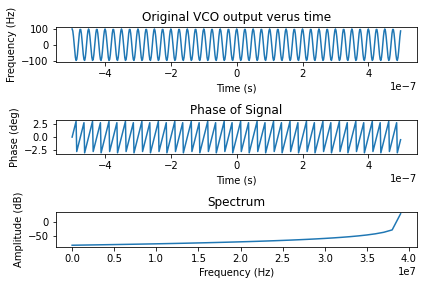

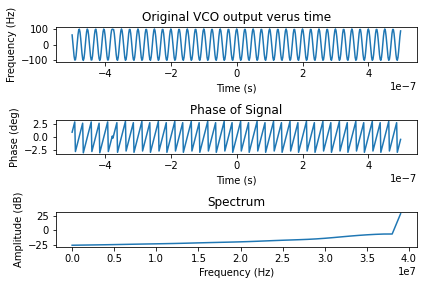

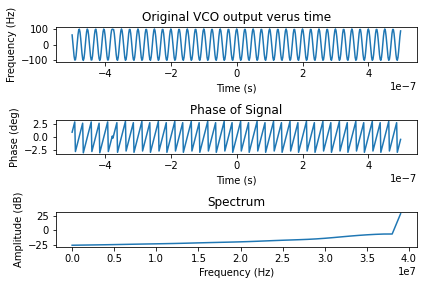

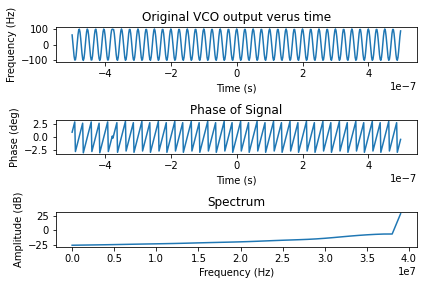

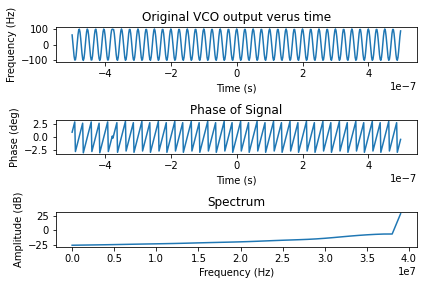

In [5]:
words = pd.read_csv("/Users/cgzog/Python_Projects/allPossible8bitWords.csv",dtype=str)      
randCodes = words.sample(n=5)
pri = 1e-3*np.ones(len(randCodes))
rf = 40e6*np.ones(len(randCodes))
bitrate = 8e6*np.ones(len(randCodes))
pw = 8/bitrate*np.ones(len(randCodes))

m = []
for code in randCodes.Code:
    m.append(code)
    
df = pd.DataFrame({"PD (usec)": pw, "PRI (usec)": pri, "RF (MHz)": rf, "Code": m}).to_csv("pulseTrainTest.csv")

test = pd.read_csv("pulseTrainTest.csv",dtype={"Code":str})
pdArray =  test["PD (usec)"]
priArray = test["PRI (usec)"]
RF = test["RF (MHz)"]
#test = pd.read_csv("pulseTrainTest.csv",dtype=str)
code = test["Code"]

A = 100
pd_idx = np.arange(0,len(pdArray))
start = time.time()
idx = 0
fs = 500e6
fc = 40e6
pri = 1e-3
noiseAmp = 500
bitrate = 8e6
pw = 8/bitrate
lowRF = 0
highRF = 250e6
while idx < test.shape[0]:
    t = np.arange(-pw/2, pw/2, 1/fs)
    pulse = make_BPSK_pulse(A, code[idx], fs, fc, 1/bitrate)  # decide later
    #def plot_data(matchedFilter,fs,minbit,bitsPerWord,m,fc,fdev):
    plot_data(pulse,fs,1/bitrate,8,fc,0)
    if idx == 0:
        train = make_pulse_train([], pulse, pw, pri, fs, lowRF, highRF, noiseAmp)
    if idx > 0:
        train = make_pulse_train(train, pulse, pw, pri, fs, lowRF, highRF, noiseAmp)
    idx += 1

In [6]:
signal = torch.zeros([1,1,len(train)],dtype=torch.cfloat)
signal[0,0,:] = torch.complex(torch.tensor(train.real),torch.tensor(train.imag))

### Sanity check raw signal

(2500000,)


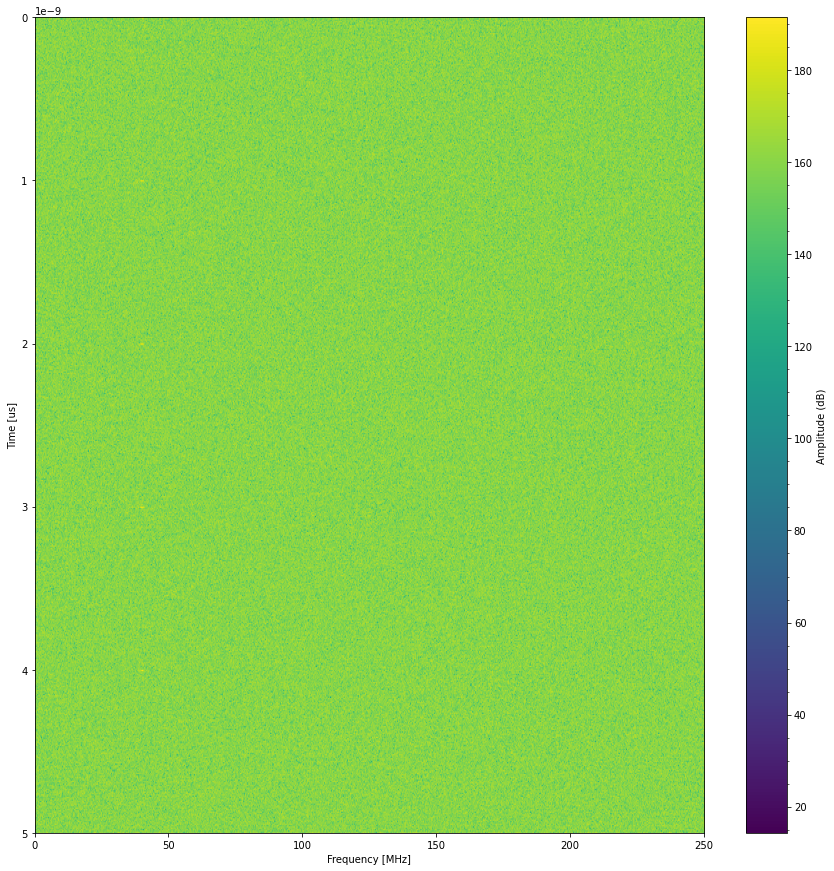

In [7]:
plot_spectral(2**12, train, fs)

# Create Filters

In [8]:
words = pd.read_csv("/Users/cgzog/Python_Projects/allPossible8bitWords.csv",dtype=str)
fs = 500e6
bitrate = 8e6
A = 100
fc = 40e6
pw = 8/bitrate
t = np.arange(-pw/2, pw/2, 1/fs)
filterBank = torch.zeros([words.shape[0],1,len(t)],dtype=torch.cfloat)
for index,row in words.iterrows():
    pulse = make_BPSK_pulse(A, words.Code[idx], fs, fc, 1/bitrate)  # decide later
    complexPulse = torch.complex(torch.tensor(pulse.real),torch.tensor(pulse.imag))
    filterBank[index,0,:] = complexPulse

# Convolve Signal With Filters

### PyTorch Way

Let's say we want to convolve f[n] and g[n] 
where both f and g are sequences of complex numbers.  Say f[n] = f_r[n] + 
jf_i[n] and g[n] = g_r[n] + jg_i[n].  
  
f[n] * g[n]  
= (f_r[n] + jf_i[n]) * (g_r[n] + jg_i[n])    
= f_r[n]*g_r[n] + j f_r[n]*g_i[n] + j f_i[n]*g_r[n] - f_i[n]*g_i[n]  
= (f_r[n]*g_r[n] - f_i[n]*g_i[n]) + j(f_r[n]*g_i[n] + f_i[n]*g_r[n]))

In [9]:
#variables: signal is my complex signal, filterBank is my complex filterBank
outputs = cmplxCnv(signal,filterBank)

TypeError: __init__() missing 1 required positional argument: 'kernel_size'

### Numpy/Scipy Way

In [ ]:
tmp = signal.data.cpu().numpy()
scipySig = tmp[0,0,:]
scipyFilters = filterBank.data.cpu().numpy()
outConvs = np.zeros([scipyFilters.shape[0],len(scipySig)])

In [ ]:
idx = 0
while idx < scipyFilters.shape[0]:
    tmp = sciSig.convolve(scipySig.real, scipyFilters[idx,0,:].real, mode='same')
    outConvs[idx,:] = 20 * np.log10(np.abs(tmp)/np.mean(tmp))
    idx += 1

In [ ]:
# So now have an array of output convolutions at sample rate, and 
# need to downsample/bitvote back to the bitrate, then spit out binary
outConvs[0]

In [ ]:
toa = np.arange(0,len(scipySig)/fs,1/fs)

In [ ]:
plt.plot(toa, outConvs[15])

In [ ]:
int('00001111',2)

In [ ]:
# Function convolved with input is called convolution kernel